# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.


<b>Подключение необходимых библиотек</b><br>
Все функции для предобработки текста находятся в файле `preprocessing.py`

In [1]:
import pandas as pd
import numpy as np
import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

<b>Загрузка таблицы</b>

In [2]:
data = pd.read_csv('dataset/train.tsv', delimiter='\t')

In [3]:
data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [4]:
data['title'][0]

'Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы'

<b>Проверка пропущенных значений</b>

In [5]:
data.isnull().sum()

title      0
is_fake    0
dtype: int64

<b>В тренировочном датасете бъеков класса 0 и объектов класса 1 одинаковое количество </b>

0    2879
1    2879
Name: is_fake, dtype: int64
Всего тайтлов: 5758


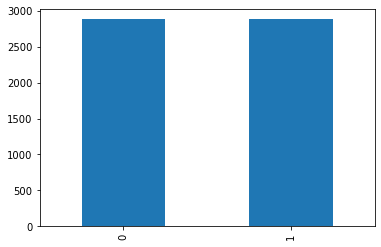

In [6]:
data['is_fake'].value_counts().plot(kind = 'bar')
print(data['is_fake'].value_counts())
count = data['is_fake'].count()
print(f'Всего тайтлов: {count}')

<b>Частота слов в заголовках новостей, которые отмечены как фейки</b>

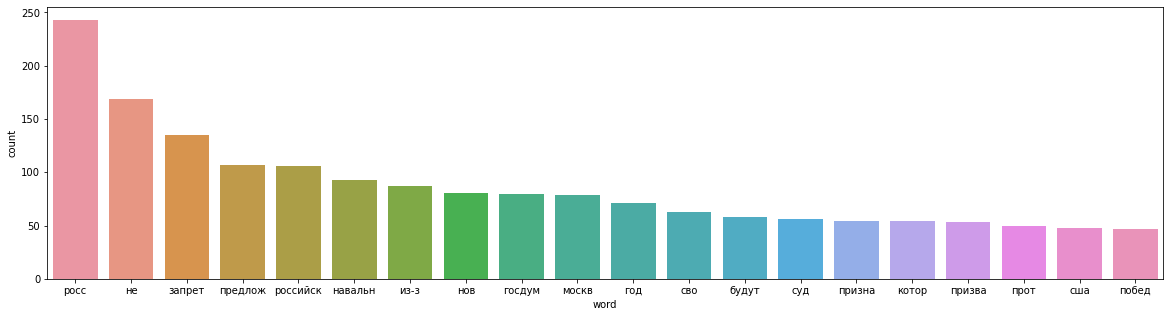

In [7]:
fake = preprocessing.get_corpus(data, 1)
preprocessing.freq_words(fake)

<b>Частота слов в заголовках новостей, которые отмечены как `не` фейки</b>

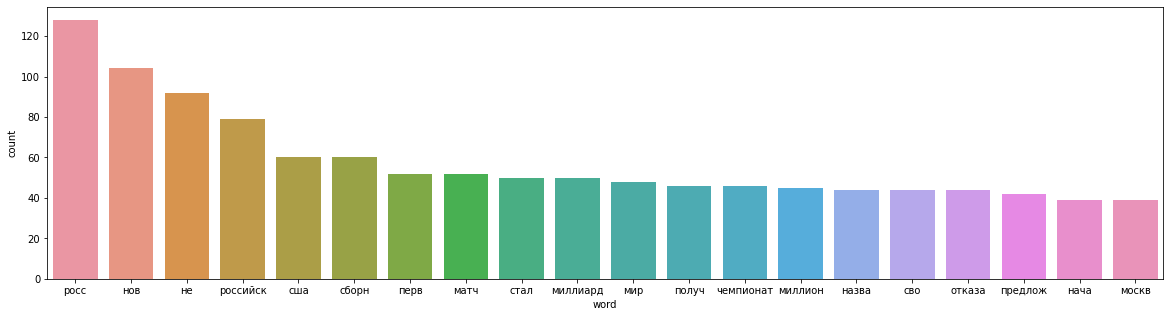

In [8]:
true = preprocessing.get_corpus(data, 0)
preprocessing.freq_words(true)

<b>Разбиение на тренировочную и тестовую выборки</b>

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data['title'], data['is_fake'], train_size=0.8, random_state=0)

 Подготовка пайплайна, где первым шагом выполняется векторизация текста для того, чтобы модель могла с ним работать. Вторым шагом строится модель логистической регрессии.<br> 
 Так можно будет получить вероятность принадлежности новости к положительному классу.

In [10]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: preprocessing.preprocessing_text(x))),
    ('model', LogisticRegression())
])

Обучение модели и расчет метрик

In [11]:
model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x00000276861E7B80>)),
                ('model', LogisticRegression())])

In [12]:
def print_metrics(y, model, x):
    y_pred = model.predict(x)
    print(f'Accuracy: {accuracy_score(y, y_pred)}')
    print(f'Precision: {precision_score(y, y_pred)}')
    print(f'Recall: {recall_score(y, y_pred)}')
    print(f'F1: {f1_score(y, y_pred)}')

In [13]:
print_metrics(y_test, model, x_test)

Accuracy: 0.8515625
Precision: 0.8502495840266223
Recall: 0.8631756756756757
F1: 0.8566638725901091


In [14]:
print_metrics(y_train, model, x_train)

Accuracy: 0.9591836734693877
Precision: 0.963355408388521
Recall: 0.9540883253170092
F1: 0.9586994727592266


На тестовой выборке метрика F1 получилась 0.856, а на тренировочной 0.958<br>
Чтобы увеличить F1 на тестовой выборке, пробую подобрать параметры для модели

In [15]:
clf = GridSearchCV(estimator=model,
                                 param_grid={'vectorizer__ngram_range':[(1, 1), (1, 2), (1, 3), (1, 4)],
                                             'model__C': [0.001, 0.01, 0.1, 1, 10]},
                                 scoring='f1',
                                 cv=5,
                                 verbose=4,
                                 n_jobs=-1)


In [16]:
clf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(tokenizer=<function <lambda> at 0x00000276861E7B80>)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                     (1, 4)]},
             scoring='f1', verbose=4)

Сохранение модели с лушими параметрами

In [17]:
best_clf = clf.best_estimator_
best_clf

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function <lambda> at 0x00000276861E7B80>)),
                ('model', LogisticRegression(C=10))])

Метрики на тестовой и на тренировочной выборках

In [18]:
print_metrics(y_test, best_clf, x_test)

Accuracy: 0.8645833333333334
Precision: 0.8516129032258064
Recall: 0.8918918918918919
F1: 0.8712871287128713


На тестовой выборке удалось увеличить метрику F1 до 0.87

In [19]:
print_metrics(y_train, best_clf, x_train)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


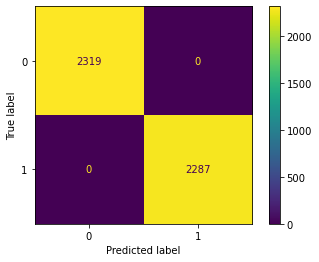

In [20]:
plot_confusion_matrix(best_clf, x_train, y_train)  
plt.show()

Но на тренировочной выборке все метрики получились 1.0, а значит, модель переобучилась и запомнила все ответы <br>
Пробую изменить параметры

In [21]:
model0 = model1 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: preprocessing.preprocessing_text(x), ngram_range=(1,1))),
    ('model', LogisticRegression())
])
model1 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: preprocessing.preprocessing_text(x), ngram_range=(1,2))),
    ('model', LogisticRegression())
])

model2 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: preprocessing.preprocessing_text(x), ngram_range=(1,3))),
    ('model', LogisticRegression())
])

model3 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: preprocessing.preprocessing_text(x), ngram_range=(1,4))),
    ('model', LogisticRegression())
])

model0.fit(x_train, y_train)
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
model3.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 4),
                                 tokenizer=<function <lambda> at 0x0000027686E5D790>)),
                ('model', LogisticRegression())])

In [22]:
for mdl in [model0, model1, model2, model3]:
    y_pred = mdl.predict(x_train)
    print(f'MSE: {mean_squared_error(y_train, y_pred)}')
    print(f'F1: {f1_score(y_train, y_pred)}')

MSE: 0.04081632653061224
F1: 0.9586994727592266
MSE: 0.011723838471558836
F1: 0.9881734559789751
MSE: 0.005644811115935736
F1: 0.994305738063951
MSE: 0.00303951367781155
F1: 0.9969365426695843


In [23]:
for mdl in [model0, model1, model2, model3]:
    y_pred = mdl.predict(x_test)
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')

MSE: 0.1484375
F1: 0.8566638725901091
MSE: 0.15104166666666666
F1: 0.8559602649006623
MSE: 0.15885416666666666
F1: 0.8493827160493826
MSE: 0.16145833333333334
F1: 0.8475409836065574


Лучше всех сработала model0 со стандартными параметрами <br>

In [24]:
prec, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model0.predict_proba(x_test)[:,1])

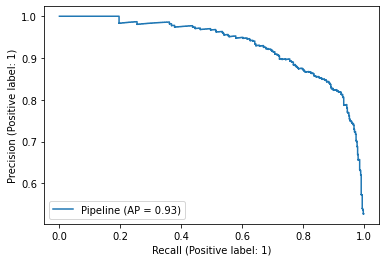

In [25]:
plot_precision_recall_curve(estimator=model0, X=x_test, y=y_test)

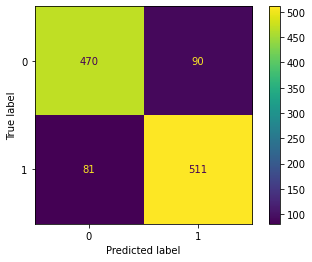

In [26]:
plot_confusion_matrix(model0, x_test, y_test)  
plt.show()

Применение модели для классификации тестового датасета и сохранение результатов

In [34]:
test_data = pd.read_csv('dataset/test.tsv', delimiter='\t')

In [35]:
test_data.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [36]:
predicted = model0.predict(test_data['title'])

In [37]:
test_data['is_fake'] = predicted

In [38]:
test_data.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


1    504
0    496
Name: is_fake, dtype: int64
Всего тайтлов: 1000


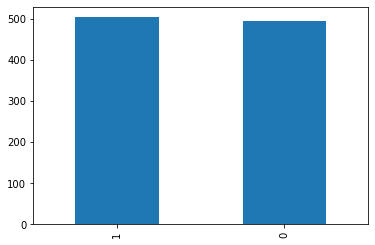

In [39]:
test_data['is_fake'].value_counts().plot(kind = 'bar')
print(test_data['is_fake'].value_counts())
count = test_data['is_fake'].count()
print(f'Всего тайтлов: {count}')

In [43]:
test_data.to_csv('predictions.tsv', sep='\t', index=False)